### Train ETH data to CNN generative network

In [83]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [84]:
from ReadData import ReadETHFolder, ReadETHFile
foldername="./ETH_Data/v/"
currentname = "./ETH_Data/"+"currents_3787.h5"
file_num = 20
data_shape = (16,16,16,3)
Bfield = torch.tensor(ReadETHFolder(foldername,file_num, data_shape)).permute(0,4,1,2,3)
current = torch.tensor(ReadETHFile(currentname))
current = current[0:Bfield.shape[0],:]


In [78]:
print(Bfield.shape)
print(current.shape)

torch.Size([20, 3, 16, 16, 16])
torch.Size([20, 8])


In [85]:
#data normalization
#find min and max value of input position and Bfield
max_current, max_current_index = torch.max(current, dim=0, keepdim=True)
# print(max_current)
min_current, min_current_index = torch.min(current, dim=0, keepdim=True)
# print(min_current)

max_Bfield, max_Bfield_index = torch.max(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(min_Bfield)

dimB = Bfield.shape
dimc = current.shape

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(min_current.shape)
print(max_current.shape)
print(min_Bfield.shape)
print(max_Bfield.shape)

# torch.save(min_current, "./normalize_data/cnn_min_current_ETH.pt")
# torch.save(max_current, "./normalize_data/cnn_max_current_ETH.pt")
# torch.save(min_Bfield, "./normalize_data/cnn_min_Bfield_ETH.pt")
# torch.save(max_Bfield, "./normalize_data/cnn_max_Bfield_ETH.pt")

tensor([[0.2649],
        [0.3060],
        [0.1957]], dtype=torch.float64)
tensor([[-0.3492],
        [-0.2553],
        [-0.1808]], dtype=torch.float64)
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([3, 1])
torch.Size([3, 1])


In [86]:
MaxB=maxB.cuda(0)
MinB=minB.cuda(0)
print(MaxB.device)
print(MinB.device)

cuda:0
cuda:0


In [127]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop import train_part_GM,get_mean_of_dataloader
from tqdm import tqdm

batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=current_norm,
    train_y=Bfield_norm
)
###############################################
# Config the neural network
###############################################
num_input = 8
output_shape = (3,16,16,16)
SB_args = (64,64,1,4) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
epochs = 3000
learning_rate_decay = .5
learning_rates = [1e-3]
RMSE_lr = []
schedule = []
linear_lr = False
weight_decays = [0]

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in tqdm(learning_rates):
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)

            get_mean_of_dataloader(valid_loader,model=Generative_network,device=device)
            print("----------------------------")
            
            print("----------------------------")
            # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            Generative_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':Generative_network.parameters()}], lr=learning_rate, weight_decay= weight_decay, betas=(0.5,0.99))
            RMSE_history, RMSE_val_history, loss_history, iter_history, mse_history, mse_val_history,epoch_stop,Rsquare= train_part_GM(
                model=Generative_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, 
                learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, DF=DF,verbose=False, device=device, maxB=MaxB[0,:], minB=MinB[0,:],
                lr_max=learning_rate, lr_min=1e-9,max_epoch=epochs, linear_lr=linear_lr, grid_space=dimB[2]*dimB[3]*dimB[4])
        
        RMSE_lr.append(RMSE_val_history[epoch_stop].item())
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    mse_history_end[index] = mse_history[epoch_stop]
    mse_val_history_end[index] = mse_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)
torch.save(Generative_network, 'EMS_CNN.pt')	# 这里会存储迄今最优模型的参数
print(RMSE_lr)
print(learning_rates)
print(RMSE_lr[0],learning_rates[0])


train_percent 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------
----------------------------
Epoch 0, Iteration 1, loss = 0.6714
Got rmse 4415.879987449218
Got rmse 3785.2720862256992

Epoch 1, Iteration 2, loss = 0.8523
Got rmse 3217.7136810035145
Got rmse 3252.4647903329133

Epoch 2, Iteration 3, loss = 0.5354
Got rmse 1520.525716320853
Got rmse 1820.78355856131

Epoch 3, Iteration 4, loss = 0.3859
Got rmse 1021.2344606785106
Got rmse 1408.4759291372804

Epoch 4, Iteration 5, loss = 0.3681
Got rmse 766.8859106283902
Got rmse 1221.4150133818168

Epoch 5, Iteration 6, loss = 0.2916
Got rmse 385.1567917200661
Got rmse 695.5578639982509

Epoch 6, Iteration 7, loss = 0.2804
Got rmse 347.8418726590035
Got rmse 752.3019406692367

Epoch 7, Iteration 8, loss = 0.2987
Got rmse 109.7838706853422
Got rmse 234.08235124672626

Epoch 8, Iteration 9, loss = 0.2344
Got rmse 119.39285676190795
Got rmse 320.90520314916

Epoch 9, Iteration 10, loss = 0.2524
Got rmse 93.66140438038366
Got rmse 197.60341303548228

Epoch 10, Iteration 11, l

100%|██████████| 1/1 [01:38<00:00, 98.34s/it]

Epoch 2995, Iteration 2996, loss = 0.0015
Got rmse 67.69655850831252
Got rmse 0.407090211468932

Epoch 2996, Iteration 2997, loss = 0.0015
Got rmse 67.69655872011408
Got rmse 0.40708946417809777

Epoch 2997, Iteration 2998, loss = 0.0015
Got rmse 67.69655819829863
Got rmse 0.407090101989054

Epoch 2998, Iteration 2999, loss = 0.0015
Got rmse 67.69655789684204
Got rmse 0.4070876493408484

Epoch 2999, Iteration 3000, loss = 0.0015
Got rmse 67.69655793500014
Got rmse 0.4070879439014605

training stop at epoch: 2999
training stop at epoch: tensor(-0.0827, device='cuda:0', dtype=torch.float64)
[67.6965560913086]
[0.001]
67.6965560913086 0.001


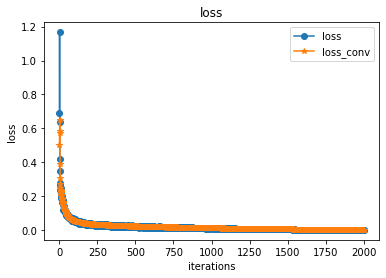

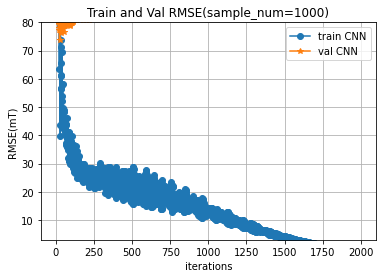

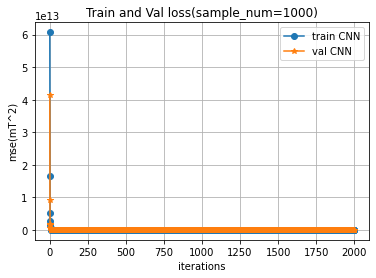

1999


In [103]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')


plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-*')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_history[0:epoch_stop]*1000,'-o')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_val_history[0:epoch_stop]*1000,'-*')
plt.ylim([3,80])
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.grid()
plt.show()

plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],mse_history[0:epoch_stop]*1e6,'-o')
plt.plot(iter_history[0:epoch_stop],mse_val_history[0:epoch_stop]*1e6,'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('mse(mT^2)')
plt.grid()
plt.show()
print(epoch_stop)
